In [15]:
from aiida import orm, load_profile
load_profile()

from aiida_atomistic.data.structure import StructureData

import numpy as np
import matplotlib.pyplot as plt


# Performance test atomistic.StructureData vs orm.StructureData

- Increase linearly the number of atoms in both cases(2D plot), 
- Then see how the scaling changes if I also defined more and more related properties (2D countour plot?)

In [16]:
properties = {
    "cell":{"value":[[1,0,0],[0,1,0],[0,0,1]]},
    "positions":{"value":[[1,1,1]]},
    "symbols":{"value":["He"]},
    }

In [17]:
structure = StructureData(properties = properties)

In [18]:
structure.properties.get_stored_properties()

['cell', 'pbc', 'symbols', 'mass', 'positions']

In [19]:
legacy = orm.StructureData(cell=properties['cell']['value'])
for position,symbol in list(zip(properties['positions']['value'],properties['symbols']['value'])):
    legacy.append_atom(position=position,symbols=symbol)

## Test 1. only increasing number of atoms.

In [20]:
def generate_simple_atomistic(properties):
    return StructureData(properties = properties)

def generate_simple_orm(cell, zipped):
    legacy = orm.StructureData(cell=cell)
    for position,symbol in zipped:
        legacy.append_atom(position=position,symbols=symbol)
    
    return legacy

def timing_atomistic_and_orm(properties, factor_list=[1]):
    """
    timing function for the generation of atomistic and orm StructureData
    without considering additional properties apart cell, positions, symbols
    """
    import time
    time_list_atom = []
    time_list_orm = []
    cell = properties['cell']['value']
    initial_pos = [[1,1,1]]
    initial_symb = ['H']
    
    for factor in factor_list:
        properties['positions']['value']=initial_pos*factor
        properties['symbols']['value']=initial_symb*factor
        zipped = list(zip(properties['positions']['value'],properties['symbols']['value']))

        t_i_atom=time.time()
        atomistic = generate_simple_atomistic(properties)
        t_f_atom=time.time()
        time.sleep(0.0001)
        t_i_orm=time.time()
        legacy = generate_simple_orm(cell, zipped) 
        t_f_orm=time.time()
        time_list_atom.append(t_f_atom-t_i_atom)
        time_list_orm.append(t_f_orm-t_i_orm)
        
        properties['positions']['value']=initial_pos
        properties['symbols']['value']=initial_symb
    
    return np.array(time_list_atom),np.array(time_list_orm),np.array(factor_list)

In [21]:
properties = {
    "cell":{"value":[[1,0,0],[0,1,0],[0,0,1]]},
    "positions":{"value":[[1,1,1]]},
    "symbols":{"value":["He"]},
    }
t_atom, t_orm, factors = timing_atomistic_and_orm(properties,factor_list=list(range(1,501)))
#print(t_atom, t_orm, factors)

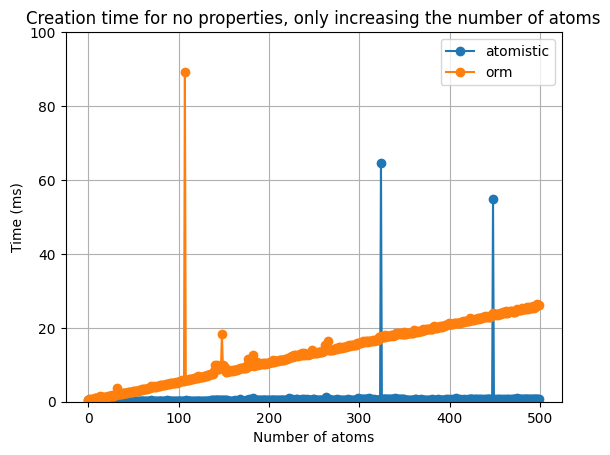

In [22]:
plt.plot(t_atom*1000, label='atomistic', marker='o')
plt.plot(t_orm*1000, label='orm', marker='o')
plt.grid()
plt.ylim(0,100)
plt.ylabel('Time (ms)')
plt.xlabel('Number of atoms')
plt.title('Creation time for no properties, only increasing the number of atoms')
plt.legend()

In [23]:
properties

{'cell': {'value': [[1, 0, 0], [0, 1, 0], [0, 0, 1]]},
 'positions': {'value': [[1, 1, 1]]},
 'symbols': {'value': ['H']}}

## Test 2. Adding properties and increasing number of atoms.

In [24]:
def timing_atomistic_and_orm_properties(properties, factor_list=[1], props_num=2):
    """
    timing function for the generation of atomistic and orm StructureData
    considering additional properties and additional atoms.
    """
    import time
    time_list_atom = []
    time_list_orm = []
    cell = properties['cell']['value']
    initial_pos = [[1,1,1]]
    initial_symb = ['H']
    initial_charge = [1]
    initial_mass = [1]
    initial_kinds = ['H1']
        
    for factor in factor_list:
        properties['positions']['value']=initial_pos*factor
        properties['symbols']['value']=initial_symb*factor
        properties['charge']= {'value':initial_charge*factor}
        properties['mass']= {'value':initial_mass*factor}
        properties['kinds']= {'value':initial_kinds*factor}
        
        if props_num==1: 
            properties.pop('kinds')
            properties.pop('mass')
            
        elif props_num==3:
            properties.pop('kinds')
            #properties.pop('charge')
            
        elif props_num==4:
            #properties.pop('kinds')
            properties.pop('charge')
        
        zipped = list(zip(properties['positions']['value'],properties['symbols']['value']))
        

        t_i_atom=time.time()
        atomistic = generate_simple_atomistic(properties)
        t_f_atom=time.time()
        time.sleep(0.0001)
        t_i_orm=time.time()
        legacy = generate_simple_orm(cell, zipped) 
        t_f_orm=time.time()
        time_list_atom.append(t_f_atom-t_i_atom)
        time_list_orm.append(t_f_orm-t_i_orm)
        
        properties['positions']['value']=initial_pos
        properties['symbols']['value']=initial_symb
        properties['charge']= {'value':initial_charge}
        properties['mass']= {'value':initial_mass}
        properties['kinds']= {'value':initial_kinds}
    
    return np.array(time_list_atom),np.array(time_list_orm),np.array(factor_list)

In [25]:
properties = {
    "cell":{"value":[[1,0,0],[0,1,0],[0,0,1]]},
    "positions":{"value":[[1,1,1]]},
    "symbols":{"value":["He"]},
    }
t_atom_props, t_orm_props, factors = timing_atomistic_and_orm_properties(properties,factor_list=list(range(1,501))) # charge, mass, and kinds check
#t_atom_props_2, t_orm_props, factors = timing_atomistic_and_orm_properties(properties,factor_list=list(range(1,501)),props_num=1) # charge, automatic masses and no kinds check
t_atom_props_3, t_orm_props, factors = timing_atomistic_and_orm_properties(properties,factor_list=list(range(1,501)),props_num=3) # no kinds check, but charge and masses
t_atom_props_4, t_orm_props, factors = timing_atomistic_and_orm_properties(properties,factor_list=list(range(1,501)),props_num=4) # no charge, but mass and kinds check

#print(t_atom, t_orm, factors)

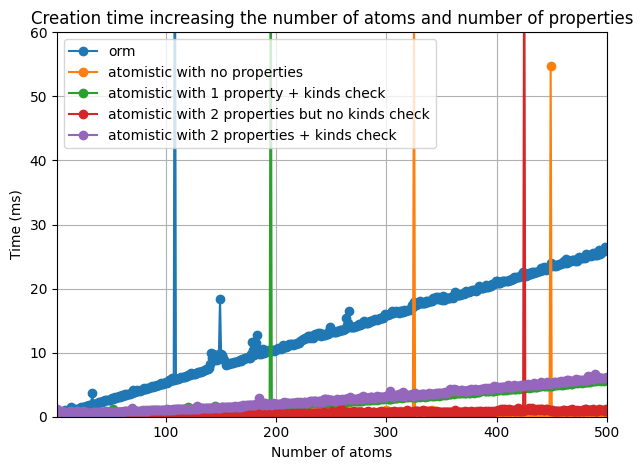

In [26]:

plt.plot(factors,t_orm*1000, label='orm', marker='o')
plt.plot(factors,t_atom*1000, label='atomistic with no properties', marker='o')
plt.plot(factors,t_atom_props_4*1000, label='atomistic with 1 property + kinds check', marker='o')
plt.plot(factors,t_atom_props_3*1000, label='atomistic with 2 properties but no kinds check', marker='o')
plt.plot(factors,t_atom_props*1000, label='atomistic with 2 properties + kinds check', marker='o')
#plt.plot(t_atom_props_2*1000, label='atomistic with charge, automatic masses and no kinds check', marker='o')
plt.ylabel('Time (ms)')
plt.xlabel('Number of atoms')
plt.title('Creation time increasing the number of atoms and number of properties')
plt.grid()
plt.xlim(1,500)
plt.ylim(0,60)
plt.legend()
plt.tight_layout()
plt.savefig('scaling_after_optimizations_deepcopy.png')

The main difference is that to create the orm.StructureData we need to loop and append atoms.

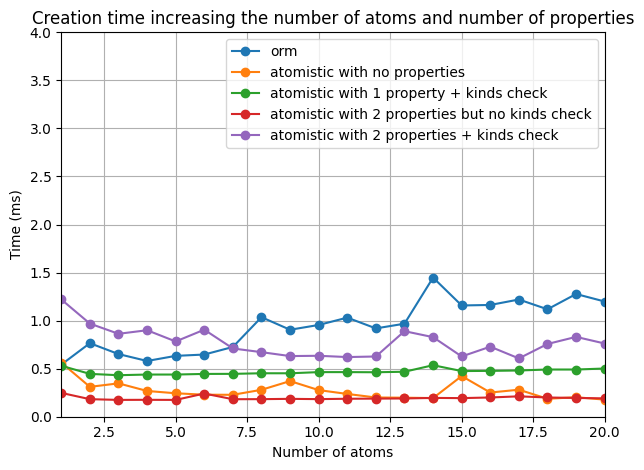

In [27]:

plt.plot(factors,t_orm*1000, label='orm', marker='o')
plt.plot(factors,t_atom*1000, label='atomistic with no properties', marker='o')
plt.plot(factors,t_atom_props_4*1000, label='atomistic with 1 property + kinds check', marker='o')
plt.plot(factors,t_atom_props_3*1000, label='atomistic with 2 properties but no kinds check', marker='o')
plt.plot(factors,t_atom_props*1000, label='atomistic with 2 properties + kinds check', marker='o')
#plt.plot(t_atom_props_2*1000, label='atomistic with charge, automatic masses and no kinds check', marker='o')
plt.ylabel('Time (ms)')
plt.xlabel('Number of atoms')
plt.title('Creation time increasing the number of atoms and number of properties')
plt.grid()
plt.xlim(1,20)
plt.ylim(0,4)
plt.legend()
plt.tight_layout()
plt.savefig('scaling_after_optimizations_deepcopy_details.png')

### Comments:

- The kinds check introduce additional steps, because the get_kinds method has a loop on the number of properties. So this should scale with them;
- Seems anyway that adding a property (from 1 to 2, both with kinds check) is not a linear scaling, but lower. This is good, and means that the internal validation of properties does not slow down too much;
- Without the kinds check, we have not increasing of time for increasing number of properties. And it is way faster than orm;

**To be investigated more:** We should investigate more the case with the kinds check (of course). In particular, we should use more advanced profiling techniques to understand exactly what is slowing down the kinds check, especially for low number of atoms (<10). 

## Specific profiling

Read this: https://realpython.com/python-profiling/ ; it was obvious also from the above analysis, but it is the `get_kinds` method which slows down things. However, I used the cProfile module to profile more, and I noticed that the `is_stored` and the `deepcopy` are time consuming. 

### Improvings
I am improving the performances mainly noticing that methods called in the `PropertyCollector` init can also be called in the StructureData init, so in this way we avoid to call them each time we access the `properties` attributes of the StructureData, as it happens really often in the `get_kinds` method, which is called in the StructureData init if we define kinds.

Up to now, speed is improved by a factor of 2.

- `_inspect_properties` method
- `is_stored` method
- I do the deepcopy in the StructureData init, when I call the PropertyCollector constructor



In [2]:
from aiida import orm, load_profile
load_profile()

from aiida_atomistic.data.structure import StructureData

import numpy as np
import matplotlib.pyplot as plt

In [37]:
import cProfile
import re


sites=1

properties = {'cell': {'value': [[1, 0, 0], [0, 1, 0], [0, 0, 1]]},
 'positions': {'value': [[1, 1, 1]]*sites},
 'symbols': {'value': ['H']*sites},
 'charge': {'value': [1]*sites},
 'mass': {'value': [1]*sites},
 'kinds': {'value': ['H1']*sites}}

In [38]:
structure = StructureData(properties = properties)

In [39]:
from timeit import timeit

iterations=100
total_time = timeit("StructureData(properties = properties)", number=iterations, globals=globals())
f"Average time is {total_time / iterations:.5f} seconds"

'Average time is 0.00050 seconds'

# After the profiling and optimization:

We obtained a speed up of a factor of almost 2 or 4 in the generation of the atomistic StructureData, and the crossing point atomistic-orm, beyond that atomistic is better then orm, is for lower number of atoms (1-7), which is a lot better than before (10-70). You can check the results in the four plots. 

In [74]:
iterations=1000
timings_atomistic_2props_kinds = []
timings_atomistic_1props_kinds = []

timings_orm = []
sites=1

properties = {'cell': {'value': [[1, 0, 0], [0, 1, 0], [0, 0, 1]]},
 'positions': {'value': [[1, 1, 1]]*sites},
 'symbols': {'value': ['H']*sites},
 'charge': {'value': [1]*sites},
 'mass': {'value': [1]*sites},
 'kinds': {'value': ['H1']*sites}}

for sites in range(1,20):
    properties = {'cell': {'value': [[1, 0, 0], [0, 1, 0], [0, 0, 1]]},
    'positions': {'value': [[1, 1, 1]]*sites},
    'symbols': {'value': ['H']*sites},
    'charge': {'value': [1]*sites},
    'mass': {'value': [1]*sites},
    'kinds': {'value': ['H1']*sites}}
    
    total_time = timeit("StructureData(properties = properties)", number=iterations, globals=globals())
    f"Average time is {total_time / iterations:.5f} seconds"
    timings_atomistic_2props_kinds.append(total_time / iterations)
    
    
    properties.pop('charge')
    total_time = timeit("StructureData(properties = properties)", number=iterations, globals=globals())
    f"Average time is {total_time / iterations:.5f} seconds"
    timings_atomistic_1props_kinds.append(total_time / iterations)
    
    zipped = list(zip(properties['positions']['value'],properties['symbols']['value']))
    total_time = timeit("generate_simple_orm(properties['cell']['value'],zipped)", number=iterations, globals=globals())
    timings_orm.append(total_time / iterations)

    
    properties = {'cell': {'value': [[1, 0, 0], [0, 1, 0], [0, 0, 1]]},
    'positions': {'value': [[1, 1, 1]]},
    'symbols': {'value': ['H']},
    'charge': {'value': [1]},
    'mass': {'value': [1]},
    'kinds': {'value': ['H1']}}
    
timings_orm=np.array(timings_orm)
timings_atomistic_1props_kinds=np.array(timings_atomistic_1props_kinds)
timings_atomistic_2props_kinds=np.array(timings_atomistic_2props_kinds)

(0.0, 1.5)

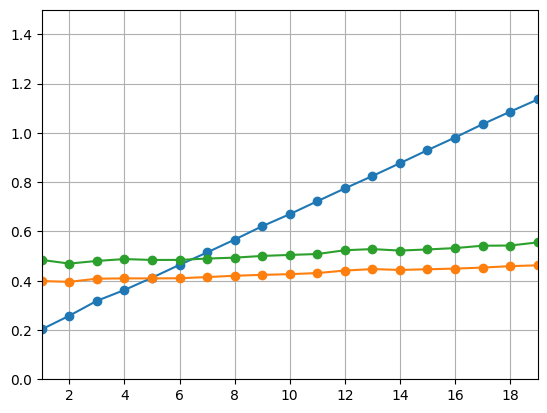

In [77]:
plt.plot(list(range(1,20)),timings_orm*1000,'o-')
plt.plot(list(range(1,20)),timings_atomistic_1props_kinds*1000, 'o-')
plt.plot(list(range(1,20)),timings_atomistic_2props_kinds*1000, 'o-')
plt.grid()
plt.xlim(1,19)
plt.ylim(0,1.5)